# ML innlevering 2 - TMDB Box Office Prediction

DET VI SKAL PREDICTE ER REVENUE PÅ HVER AV ID-ENE ("try and predict their overall worldwide box office revenue")

During this project we will use the eight steps in Appendix B:
1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

# Getting started

# Setup

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn

import joblib
from joblib import dump
from pathlib import Path

In [96]:
NB_DIR = Path.cwd()
DATA_DIR = NB_DIR/'...'/'data'

#### Get the data:

In [97]:
#lists the files in the folder
import os
print(os.listdir("data"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [98]:
#Reads in the csv-files and creates a dataframe using pandas

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sampleSubmission = pd.read_csv('data/sample_submission.csv')

## Explore the data

In [169]:
train["genres"]

0                          [{'id': 35, 'name': 'Comedy'}]
1       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                           [{'id': 18, 'name': 'Drama'}]
3       [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4       [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
                              ...                        
2995    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2996    [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...
2997    [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...
2998    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2999    [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...
Name: genres, Length: 3000, dtype: object

In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

Info gives a clean list of all the features in the train set. Most of the features are objects, except a few which are ints or floats. Info also contains info about the Non-Null numbers. Some features contains a smaller amount of Non-Null numbers, whoch means there are missing data. The column "belongs_to_collection" have a very small Non-Null so the feature probably have a lot of missing data. Lets go deeper:

The code underneath provides an overview of missing values in train. The missing values makes it harder to give good predictions, if it is not handled correctly.

In [101]:
print(train.isnull().sum())

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64


Text(0.5, 1.0, 'Missing Value count By Features')

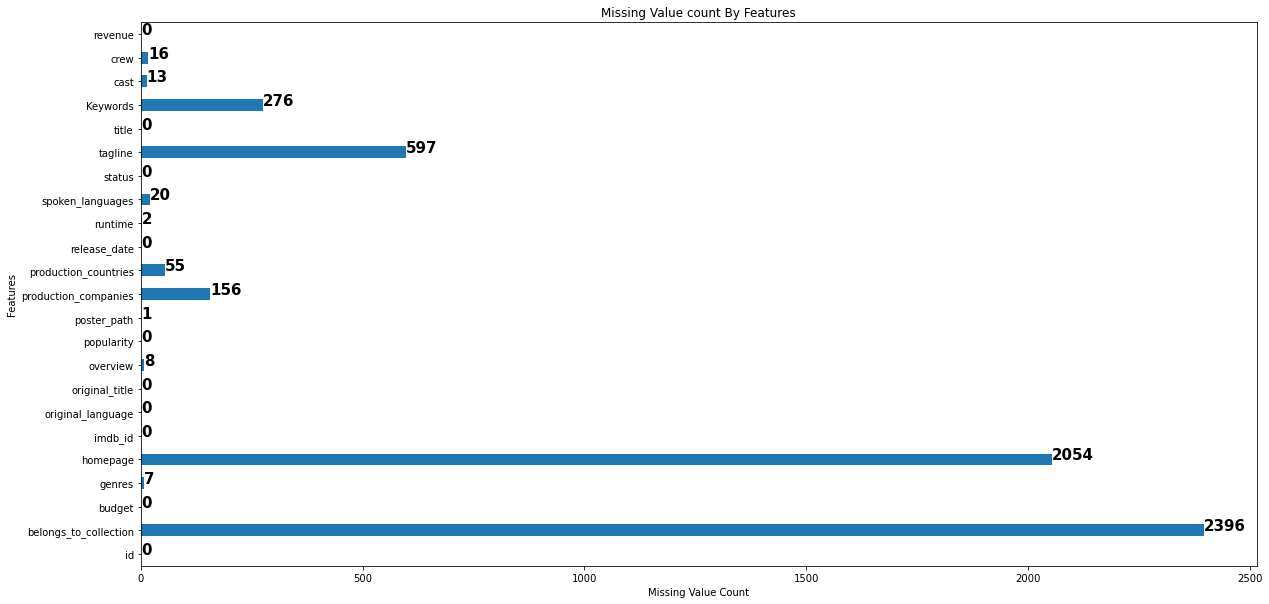

In [102]:
train.isna().sum().plot(kind="barh", figsize=(20,10))
for i, v in enumerate(train.isna().sum()):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 15)
plt.xlabel("Missing Value Count")
plt.ylabel("Features")
plt.title("Missing Value count By Features")

Homepage are one of the features that has a lot of missing values. This feature is not seen as a important feature in order to predict revenue. Therefore this feature will be dropped. 

In this first round we are dropping all the features that has missing values, and then we will keep the necessary ones and calculate the missing values

In [103]:
X = train.drop(['id', 'homepage', 'overview', 
                'poster_path','production_companies',
                'production_countries','Keywords',
            'tagline','crew'],axis=1)


#train.drop(['homepage','imdb_id','belongs_to_collection',
 #           'genres','overview','production_companies',
  #          'production_countries','poster_path','spoken_languages',
   #         'tagline','Keywords','crew','cast'],axis=1)

Underneath is a code written to fill all "nan"´s with zeros. This is done, because the movies with nan in the feature "belongs_to_collection" most likely des not belong to any collection.

In [104]:
X['belongs_to_collection'] = X['belongs_to_collection'].fillna(0)
#X['genres'] = X['genres'].fillna(0)
#X['production_companies'] = X['production_companies'].fillna(0)
#X['production_countries'] = X['production_countries'].fillna(0)
#X['runtime'] = X['runtime'].fillna(0)
#X['spoken_languages'] = X['spoken_languages'].fillna(0)
#X['Keywords'] = X['Keywords'].fillna(0)
#X['cast'] = X['cast'].fillna(0)

In [105]:
X.head()

,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,popularity,release_date,runtime,spoken_languages,status,title,cast,revenue
0,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,6.575393,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651
1,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,8.248895,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435
2,0,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,64.299990,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000
3,0,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,Kahaani,3.174936,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Kahaani,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000
4,0,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,마린보이,1.148070,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Marine Boy,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970


In [106]:
#for i, e in enumerate(train['belongs_to_collection'][:5]):
    #print(i, e)

In [107]:
X_test = test.drop("id", axis=1)
X_test.head()

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [108]:
#train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

In [109]:
X.describe()

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


If std had been 1 and mean hade been 0, it would have been a perfect result already

### Lets also understand the popularity of the genres

In [110]:
import ast

# from this kernel: https://www.kaggle.com/gravix/gradient-in-a-box
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train_vizu = text_to_dict(train)
test_vizu = text_to_dict(test)

In [111]:
for i, e in enumerate(train_vizu['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [112]:
print('Number of genres in films')
train_vizu['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [113]:
list_of_genres = list(train_vizu['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

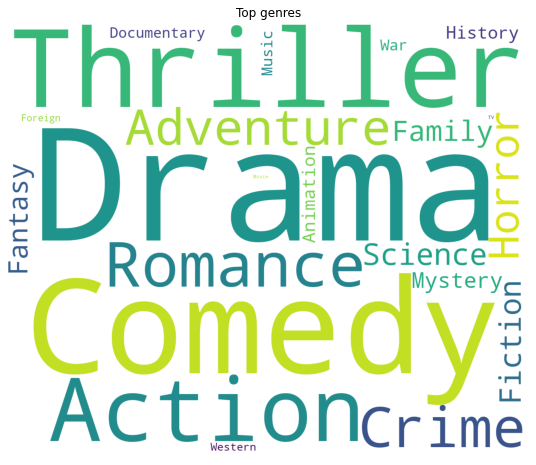

In [114]:
from wordcloud import WordCloud 

plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                        width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

A wordcloud of top genres. Here we can see that Drama, Comedy and Thriller are popular genres.

from this kernel: https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation

### Release of movies

In [115]:
#Since only last two digits of year are provided, this is the correct way of getting the year.
train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
# Some rows have 4 digits of year instead of 2, that's why I am applying (train['release_year'] < 100) this condition
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(train['release_date']) 
train['release_dayofweek'] = releaseDate.dt.dayofweek

Get Month, Day, Year and week day from release date

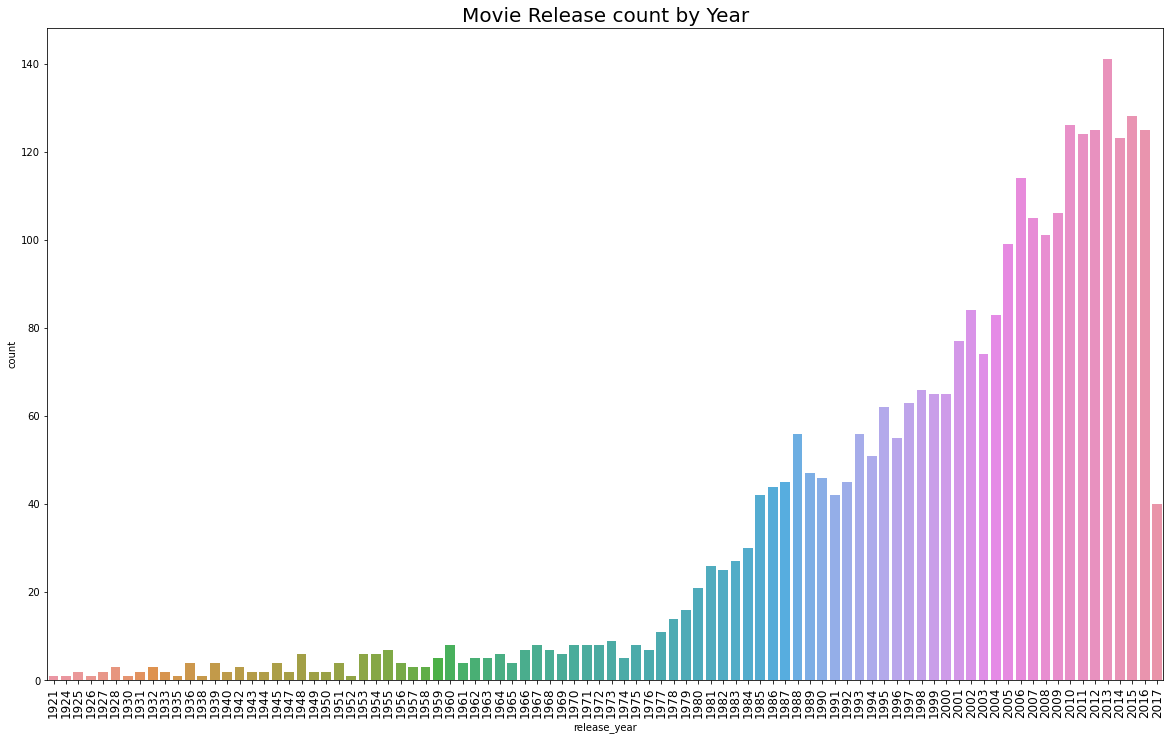

In [116]:
import seaborn as sns

plt.figure(figsize = (20, 12))
sns.countplot(train['release_year'].sort_values())
plt.title("Movie Release count by Year", fontsize = 20)
loc, labels = plt.xticks()
plt.xticks(fontsize = 12, rotation = 90)
plt.show()

A plot of release year

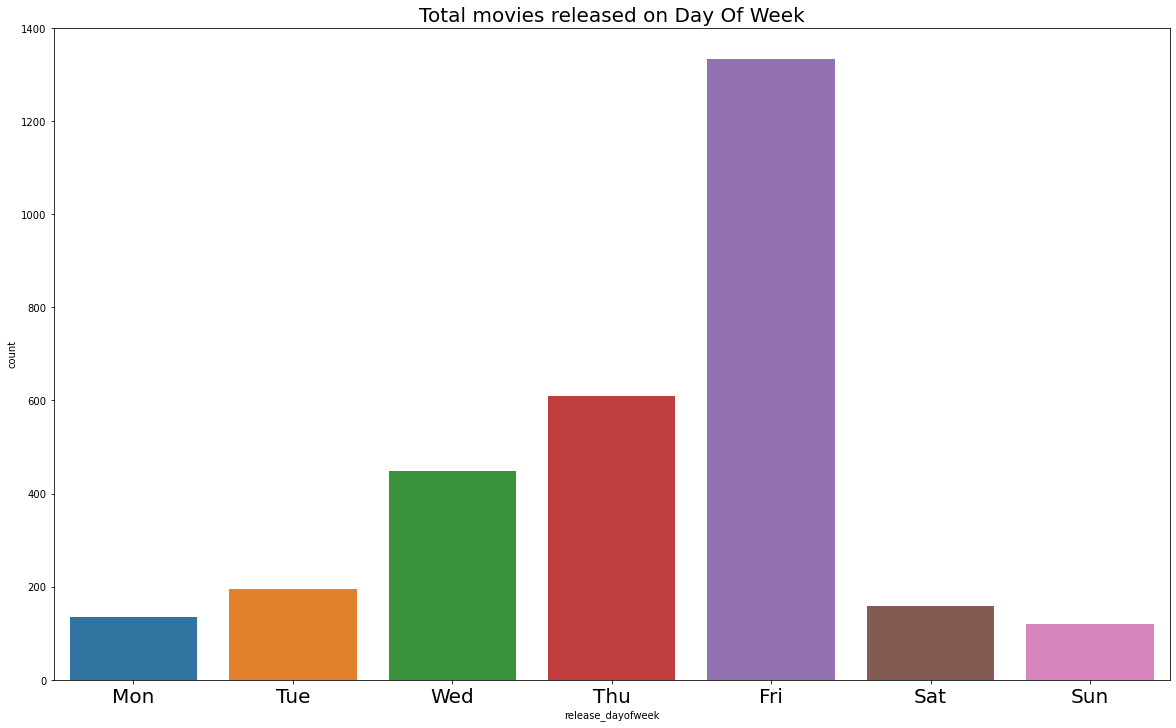

In [117]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_dayofweek'].sort_values())
plt.title("Total movies released on Day Of Week",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

A plot of release day of week

### Is the movie released?

In [118]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In the train data is 2996 movies released, and 4 movies are yet to release.

In [119]:
train.loc[train['status'] == "Rumored"][['status','revenue']]

,status,revenue
609,Rumored,273644
1007,Rumored,60
1216,Rumored,13418091
1618,Rumored,229000


This is strange, movie is yet to release and revenue is already given.

In [120]:
test['status'].value_counts()

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

In the test data is 4389 movies released, and 7 movies are yet to release.

### Keywords in movies

In [121]:
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [122]:
print('Number of Keywords in films')
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

Here we have some keywords describing films. Of course there can be a lot of them. Let's have a look at the most common ones.

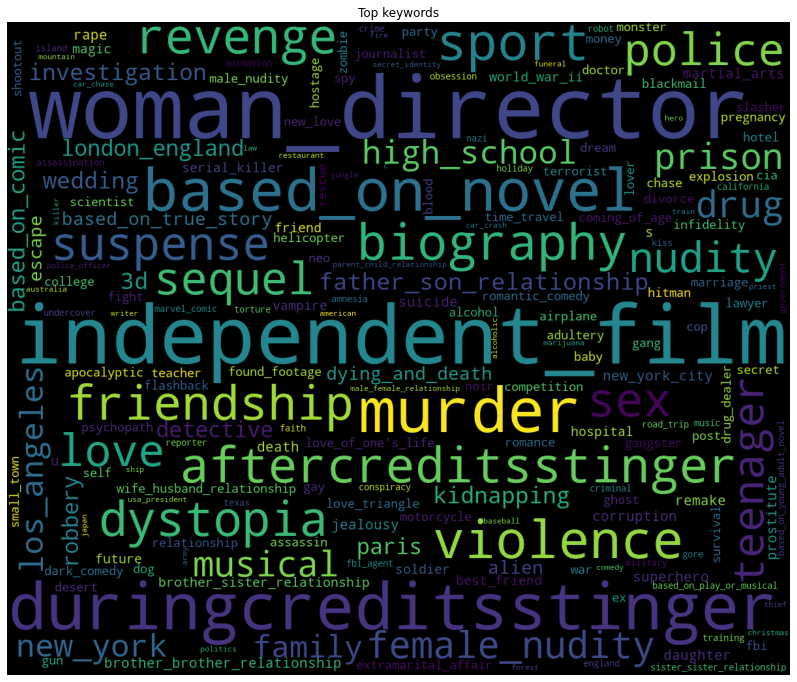

In [123]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

### Test set

In this task we were already provided with a test-set.

In [124]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,{},88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,{},0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,{},6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,{},2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [125]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  4398 non-null   object 
 2   budget                 4398 non-null   int64  
 3   genres                 4398 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4398 non-null   object 
 12  production_countries   4398 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

In [126]:
test.describe()

,id,budget,popularity,runtime
count,4398.000000,4.398000e+03,4398.000000,4394.000000
mean,5199.500000,2.264929e+07,8.550230,107.622212
std,1269.737571,3.689991e+07,12.209014,21.058290
min,3001.000000,0.000000e+00,0.000001,0.000000
25%,4100.250000,0.000000e+00,3.895186,94.000000
50%,5199.500000,7.450000e+06,7.482241,104.000000
75%,6298.750000,2.800000e+07,10.938524,118.000000
max,7398.000000,2.600000e+08,547.488298,320.000000


Observation: many NaN

In [127]:
len(test)

4398

# Handeling text

Most of the provided values are not numeric, therefore it is important to make all of the objects numeric

In [128]:
X.head()

,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,popularity,release_date,runtime,spoken_languages,status,title,cast,revenue
0,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,6.575393,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651
1,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,8.248895,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435
2,0,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,64.299990,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000
3,0,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,Kahaani,3.174936,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Kahaani,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000
4,0,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,마린보이,1.148070,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Marine Boy,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970


In [129]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

X.cast= imputer.fit_transform(X["cast"].values.reshape(-1,1))[:,0]                                                                                 

In [130]:
#X.production_companies = imputer.fit_transform(X["production_companies"].values.reshape(-1,1))[:,0]

In [131]:
#X.production_countries = imputer.fit_transform(X["production_countries"].values.reshape(-1,1))[:,0]

In [132]:
X.genres = imputer.fit_transform(X["genres"].values.reshape(-1,1))[:,0]

In [133]:
X.spoken_languages = imputer.fit_transform(X["spoken_languages"].values.reshape(-1,1))[:,0]

In [134]:
imputer1 = SimpleImputer(missing_values = np.nan, strategy = 'median')
X.runtime = imputer1.fit_transform(X["runtime"].values.reshape(-1,1))[:,0]

In [135]:
X.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  3000 non-null   object 
 1   budget                 3000 non-null   int64  
 2   genres                 3000 non-null   object 
 3   imdb_id                3000 non-null   object 
 4   original_language      3000 non-null   object 
 5   original_title         3000 non-null   object 
 6   popularity             3000 non-null   float64
 7   release_date           3000 non-null   object 
 8   runtime                3000 non-null   float64
 9   spoken_languages       3000 non-null   object 
 10  status                 3000 non-null   object 
 11  title                  3000 non-null   object 
 12  cast                   3000 non-null   object 
 13  revenue                3000 non-null   int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 328.2+

### Pipelines

In [136]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [137]:
X = X.drop([ "title", "imdb_id"], axis =1)

In [138]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  3000 non-null   object 
 1   budget                 3000 non-null   int64  
 2   genres                 3000 non-null   object 
 3   original_language      3000 non-null   object 
 4   original_title         3000 non-null   object 
 5   popularity             3000 non-null   float64
 6   release_date           3000 non-null   object 
 7   runtime                3000 non-null   float64
 8   spoken_languages       3000 non-null   object 
 9   status                 3000 non-null   object 
 10  cast                   3000 non-null   object 
 11  revenue                3000 non-null   int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 281.4+ KB


In [139]:
X_test = test

In [140]:
X_numbers = X[['budget', 'popularity', 'runtime']]

num_pipeline = Pipeline([
                ['imputer', SimpleImputer(strategy="median")],
                ['std_scaler', StandardScaler() ],                       
  ])
X_numbers_tr = num_pipeline.fit_transform(X_numbers)
X_numbers_tr

array([[-0.23045256, -0.15599768, -0.6728692 ],
       [ 0.47187212, -0.01771439,  0.23310791],
       [-0.51948618,  4.61384865, -0.12928293],
       ...,
       [ 1.14718432,  0.49736238,  0.5501999 ],
       [ 0.5258971 ,  0.6000891 , -0.80876577],
       [ 0.33680969,  0.16929745, -0.08398408]])

In [141]:
print(X.isnull().sum())

belongs_to_collection    0
budget                   0
genres                   0
original_language        0
original_title           0
popularity               0
release_date             0
runtime                  0
spoken_languages         0
status                   0
cast                     0
revenue                  0
dtype: int64


In [142]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  4398 non-null   object 
 2   budget                 4398 non-null   int64  
 3   genres                 4398 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4398 non-null   object 
 12  production_countries   4398 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

In [143]:
X_cat = X[["genres", "original_language","original_title",
           "release_date","spoken_languages","status", 
            "cast"]]

X_cat_attribs = list(X_cat)
X_numbers_attribs = list(X_numbers)

full_pipeline = ColumnTransformer([
    ["num", num_pipeline,X_numbers_attribs],
    ["cat", OneHotEncoder(handle_unknown = 'ignore'), X_cat_attribs]
])

X_prepared = full_pipeline.fit_transform(X)

In [144]:
X_prepared

<3000x9662 sparse matrix of type '<class 'numpy.float64'>'
	with 30000 stored elements in Compressed Sparse Row format>

In [145]:
#MODEL_DIR = NB_DIR/'filmApp'/'app'/'models'

In [147]:
joblib.dump(full_pipeline, 'pip.joblib')
#dump(rf, MODEL_DIR/'pipeline.joblib', compress = 1)

['pip.joblib']

# Select a model and train it

In [148]:
#Making a function to display score value
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### Linear regression model

In [173]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [174]:
y = train["revenue"].copy()
lin_reg = LinearRegression()
lin_reg.fit(X_prepared, y)

LinearRegression()

In [151]:
some_data = X.iloc[:5]
some_labels = y.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [12314674.17687263 95149438.79049025 13092138.68114141 16000086.39037043
  3924012.65658173]


In [152]:
print("Labels:", list(some_labels))

Labels: [12314651, 95149435, 13092000, 16000000, 3923970]


In [153]:
#revenue_predictions = lin_reg.predict(X_prepared)
#lin_mse = mean_squared_error(revenue_predictions, y)
#lin_rmse = np.sqrt(lin_mse)
#lin_rmse

In [154]:
lin_scores = cross_val_score(lin_reg, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [8.44840059e+07 8.78922356e+07 9.36255012e+07 8.84568784e+07
 7.90993402e+07 1.03715295e+08 6.93387322e+07 8.11383340e+07
 9.02998598e+07 8.37990298e+07]
Mean: 86184921.16952845
Standard deviation: 8693324.04016604


8.6 millions in standard deviation.

### Decision Tree Regressor

In [155]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

In [156]:
#Finding cross_val_score
scores = cross_val_score(tree_reg, 
                         X_prepared, 
                         y, 
                         scoring="neg_mean_squared_error", 
                         cv=10)
tree_rmse_scores = np.sqrt(-scores)

#Prints the tree rmse scores
display_scores(tree_rmse_scores)

Scores: [1.16295197e+08 8.50889152e+07 1.20687940e+08 1.15120473e+08
 9.44848446e+07 1.11011281e+08 1.02214353e+08 1.14084195e+08
 9.39020554e+07 8.30744286e+07]
Mean: 103596368.40089563
Standard deviation: 13014406.958665406


13 millions in standard deviation.

### Random Forest

In [157]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10)

In [158]:
#Finding cross-val-score
scores = cross_val_score(rf, X_prepared, y, 
                         scoring="neg_mean_squared_error", cv=10)
tree_mase_scores = np.sqrt(-scores)

In [159]:
forest_xmae_scores = np.sqrt(-scores)
display_scores(forest_xmae_scores)

Scores: [8.24509666e+07 8.26935305e+07 1.02148519e+08 8.50045215e+07
 7.62877359e+07 1.01253583e+08 7.77598839e+07 9.18910562e+07
 9.20758587e+07 7.34061748e+07]
Mean: 86497182.94279537
Standard deviation: 9528622.731320726


8.7 millions in standard deviation.

In [160]:
rf.fit(X_prepared, y)

RandomForestRegressor(n_estimators=10)

# Fine-tune our model

### Grid Search with Random Forest

In [161]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30], 
               'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 
               'n_estimators': [3, 10], 
               'max_features': [2, 3, 4]},]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True) 
grid_search.fit(X_prepared, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [162]:
# Vis parametre for best resultat
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [163]:
model = grid_search.best_estimator_
model

RandomForestRegressor(max_features=2, n_estimators=30)

In [164]:
model_scores = cross_val_score(model, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
model_rmse_scores = np.sqrt(-model_scores)

display_scores(model_rmse_scores)

Scores: [8.85600514e+07 8.42927223e+07 1.06358327e+08 1.04680285e+08
 7.54924784e+07 9.96846734e+07 7.80797117e+07 9.69900581e+07
 9.27544676e+07 9.39017348e+07]
Mean: 92079450.97070949
Standard deviation: 9962614.289876154


Now with Grid Search of the RandomForestRegression the standard deviation is 12 millions.

# Submission

## Present your solution

What results did we get of the prediction.

### Predict

In [165]:
test_drop = test.copy()
test_drop.drop("id", axis=1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,{},88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,{},0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,{},6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,{},2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,{},42000000,"[{'id': 53, 'name': 'Thriller'}]",NaN,tt0218922,en,Original Sin,A young man is plunged into a life of subterfu...,9.970359,/i8FEQy5IWAqOzXm4uDHy2r3Swym.jpg,...,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",8/3/01,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,This is not a love story - it's a story about ...,Original Sin,"[{'id': 515, 'name': 'women'}, {'id': 572, 'na...","[{'cast_id': 17, 'character': 'Julia Russell/B...","[{'credit_id': '52fe4330c3a36847f80412db', 'de..."
4394,"[{'id': 146534, 'name': 'Without a Paddle Coll...",19000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,tt0364751,en,Without a Paddle,"Three friends, whose lives have been drifting ...",6.046516,/oZDbFtTnTwW5GSfyaGFGaYxDBgD.jpg,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/20/04,95.0,"[{'iso_639_1': 'en', 

In [166]:
sub = pd.read_csv('data/sample_submission.csv')
df_sub = pd.DataFrame()
df_sub['id'] = sub['id']
df_sub['revenue'] = np.expm1(X_prepared*3)
#print(df_sub['revenue'])
df_sub.to_csv("submission.csv", index=False)

## Export trained model

We used joblib to export this model:

In [167]:
MODEL_DIR = NB_DIR/'filmApp'/'app'/'models'

In [168]:
dump(rf, MODEL_DIR/'filmAppmodel.joblib', compress = 6)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mariatufteland/Documents/GitHub/Dat158-ML2/filmApp/app/nbs/filmApp/app/models/filmAppmodel.joblib'